In [2]:
import pandas as pd
from google.colab import drive
import pandas as pd
import csv

# Mount Google Drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/Data/ADEnormalizationSOCTop6.tsv'
# Read the CSV file into a DataFrame
data = pd.read_csv(data_path, sep='\t')
# data = pd. DataFrame(data)
# Display the DataFrame
# print(data.head)
# # print(data['ade'],data['soc_code'])
# data['soc_code'].value_counts()
data = data[data['soc_code'] != 0]

print(data.head)

Mounted at /content/drive
<bound method NDFrame.head of       Unnamed: 0                        ade  soc_code
0              2                         AD  10037175
1              3                      focus  10029205
2              4                       died  10018065
3              5                       died  10018065
4              7                     dreams  10037175
...          ...                        ...       ...
1447        1706                     orgasm  10037175
1448        1707  never have another orgasm  10037175
1449        1708                       coma  10029205
1450        1709        gain so much weight  10022891
1451        1710         increase my weight  10022891

[1452 rows x 3 columns]>


In [1]:
!pip install transformers
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

# data.head()

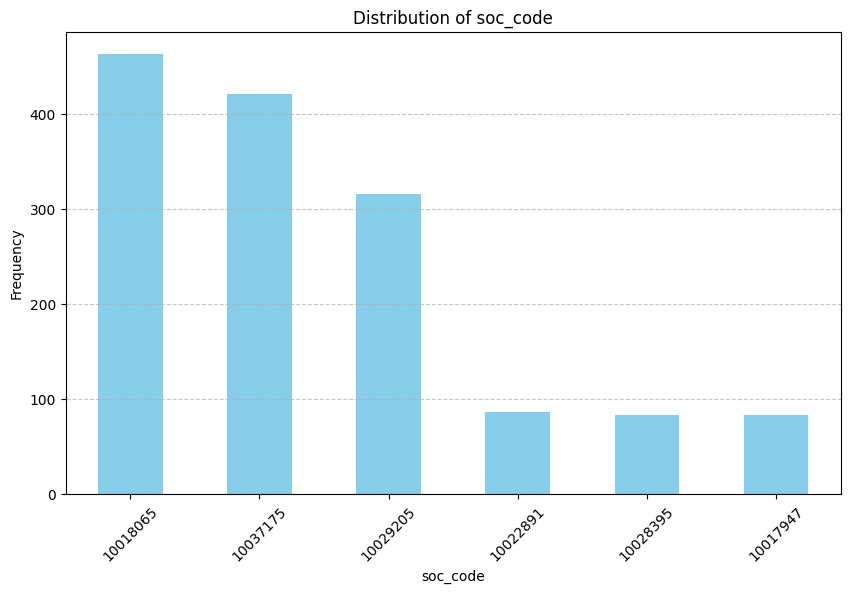

soc_code
10018065    463
10037175    421
10029205    316
10022891     86
10028395     83
10017947     83
Name: count, dtype: int64


In [3]:
import matplotlib.pyplot as plt

#plot data distribution
# Plot soc_code distribution
plt.figure(figsize=(10, 6))
data['soc_code'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of soc_code')
plt.xlabel('soc_code')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print(data['soc_code'].value_counts())
df = data

In [4]:
import pandas as pd

# Get unique labels and their counts
label_counts = df['soc_code'].value_counts()

# Sort labels by counts
sorted_labels = label_counts.index.tolist()

# Create label dictionary with labels assigned from 1 to the number of unique labels
label_dict = {label: i for i, label in enumerate(sorted_labels, 0)}

# Print label dictionary
print(label_dict)

label_df = pd.DataFrame.from_dict(label_dict, orient='index', columns=['Label'])

# Reset index to make the index a regular column
label_df.reset_index(inplace=True)

# Rename columns
label_df.columns = ['SOC Code', 'Label']

# Sort DataFrame by label
label_df = label_df.sort_values(by='Label')

# Print the DataFrame
print(label_df)

df['label'] = df.soc_code.replace(label_dict)

{10018065: 0, 10037175: 1, 10029205: 2, 10022891: 3, 10028395: 4, 10017947: 5}
   SOC Code  Label
0  10018065      0
1  10037175      1
2  10029205      2
3  10022891      3
4  10028395      4
5  10017947      5


In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

def custom_train_test_split(X, y, test_size=0.15, random_state=None):
    classes, counts = np.unique(y, return_counts=True)
    min_class_count = min(counts)

    # Find classes with only one or two instances
    single_or_double_instance_classes = classes[np.logical_or(counts == 1, counts == 2)]

    # Remove instances of single-instance or two-instance classes
    X_filtered = X[~np.isin(y, single_or_double_instance_classes)]
    y_filtered = y[~np.isin(y, single_or_double_instance_classes)]

    if len(y_filtered) < 2:
        raise ValueError("No classes have more than two instances after filtering.")

    # Perform stratified split on the filtered dataset
    X_train, X_val, y_train, y_val = train_test_split(X_filtered, y_filtered, test_size=test_size, random_state=random_state, stratify=y_filtered)

    # Randomly assign instances of single-instance classes to training or testing sets
    for class_label in single_or_double_instance_classes:
        class_indices = np.where(y == class_label)[0]
        np.random.shuffle(class_indices)

        if len(class_indices) <= 2:
            # Only one instance, randomly assign to training or testing set
            if np.random.rand() < test_size:
                X_val = np.concatenate((X_val, X[class_indices]))
                y_val = np.concatenate((y_val, y[class_indices]))
            else:
                X_train = np.concatenate((X_train, X[class_indices]))
                y_train = np.concatenate((y_train, y[class_indices]))

    return X_train, X_val, y_train, y_val

# Usage:
X_train, X_val, y_train, y_val = custom_train_test_split(df.index.values, df.label.values, test_size=0.2, random_state=42)


                          Unnamed: 0  ade
soc_code label data_type                 
10017947 5     train              66   66
               val                17   17
10018065 0     train             370  370
               val                93   93
10022891 3     train              69   69
               val                17   17
10028395 4     train              66   66
               val                17   17
10029205 2     train             253  253
               val                63   63
10037175 1     train             337  337
               val                84   84
    soc_code  label data_type  count
2   10018065      0     train    370
3   10018065      0       val     93
10  10037175      1     train    337
11  10037175      1       val     84
8   10029205      2     train    253
9   10029205      2       val     63
4   10022891      3     train     69
5   10022891      3       val     17
6   10028395      4     train     66
7   10028395      4       val     17
0   1

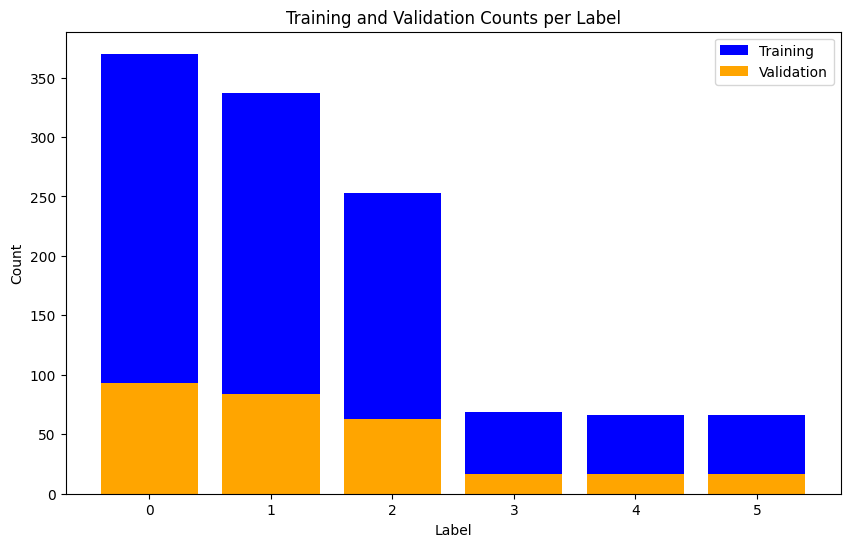

In [6]:
df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'

print(df.groupby(['soc_code', 'label', 'data_type']).count())

result = df.groupby(['soc_code', 'label', 'data_type']).size().reset_index(name='count')
result_sorted = result.sort_values(by='label')
print(result_sorted)

import matplotlib.pyplot as plt

# Group by soc_code, label, and data_type
grouped = df.groupby(['soc_code', 'label', 'data_type']).size().reset_index(name='count')

# Filter data for training and validation
train_counts = grouped[grouped['data_type'] == 'train']
val_counts = grouped[grouped['data_type'] == 'val']

# Plot the counts
plt.figure(figsize=(10, 6))
plt.bar(train_counts['label'], train_counts['count'], color='blue', label='Training')
plt.bar(val_counts['label'], val_counts['count'], color='orange', label='Validation')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Training and Validation Counts per Label')
plt.legend()
plt.show()


In [7]:
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased',
                                          do_lower_case=True)

encoded_data_train = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].ade.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].ade.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)


input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In t

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerN

In [8]:
#data loader
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 4

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

from transformers import AdamW, get_linear_schedule_with_warmup

#training parameters
optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)

epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)

#evaluation
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

# Assuming device is cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model.to(device)
print(f"Device used: {device}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Device used: cuda


In [9]:
#training
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)
        # outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)


        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.5169395286193008
Validation loss: 1.2577813876001802
F1 Score (Weighted): 0.4699422696867554


Epoch 2:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.0651671712853246
Validation loss: 0.932987610567106
F1 Score (Weighted): 0.6414045812417425


Epoch 3:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.7317207703987757
Validation loss: 1.1198246288432243
F1 Score (Weighted): 0.6754128606681952


Epoch 4:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.5659425836536534
Validation loss: 1.2170742127074772
F1 Score (Weighted): 0.6949976665431288


Epoch 5:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.39732526457721296
Validation loss: 1.2671705273247948
F1 Score (Weighted): 0.7283539441671573


Epoch 6:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.35895635862074654
Validation loss: 1.48212594125254
F1 Score (Weighted): 0.7404921548435623


Epoch 7:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.2422305387084747
Validation loss: 1.4809367226042836
F1 Score (Weighted): 0.7531720887559077


Epoch 8:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.1930208744095555
Validation loss: 1.5025878102807264
F1 Score (Weighted): 0.7688308032603592


Epoch 9:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.18964698035778044
Validation loss: 1.6307400212286691
F1 Score (Weighted): 0.7465467281431715


Epoch 10:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.13267094111834138
Validation loss: 1.662934480618912
F1 Score (Weighted): 0.7582365981415453


Epoch 11:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.12130455824230875
Validation loss: 1.7493451142696383
F1 Score (Weighted): 0.7494775834942639


Epoch 12:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.10390949362572491
Validation loss: 1.7571665612240768
F1 Score (Weighted): 0.7497596615795591


Epoch 13:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.08470123118404507
Validation loss: 1.8928840579766038
F1 Score (Weighted): 0.7291940807639027


Epoch 14:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.07120360153438396
Validation loss: 1.8458737492336483
F1 Score (Weighted): 0.7603972782094356


Epoch 15:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.061938265343740764
Validation loss: 1.8849290895332784
F1 Score (Weighted): 0.7609273484725491


Epoch 16:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.08435819080745348
Validation loss: 1.8671614050453333
F1 Score (Weighted): 0.7530280204076075


Epoch 17:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.07035841584029404
Validation loss: 1.910753901749658
F1 Score (Weighted): 0.742370107353284


Epoch 18:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.03835723933578178
Validation loss: 1.9490782537715658
F1 Score (Weighted): 0.7495247080605892


Epoch 19:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.05970283143142922
Validation loss: 1.9177794504957753
F1 Score (Weighted): 0.7594475779006258


Epoch 20:   0%|          | 0/291 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.058046577391802745
Validation loss: 1.9175005235160265
F1 Score (Weighted): 0.7531683713519693


In [10]:
#evaluation
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('./finetuned_BERT_epoch_20.model', map_location=torch.device('cpu')))

_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class: 10018065
Accuracy: 73/93

Class: 10037175
Accuracy: 62/84

Class: 10029205
Accuracy: 47/63

Class: 10022891
Accuracy: 14/17

Class: 10028395
Accuracy: 13/17

Class: 10017947
Accuracy: 10/17



{0: 0.7849462365591398, 1: 0.7380952380952381, 2: 0.746031746031746, 3: 0.8235294117647058, 4: 0.7647058823529411, 5: 0.5882352941176471} {0: 93, 1: 84, 2: 63, 3: 17, 4: 17, 5: 17}


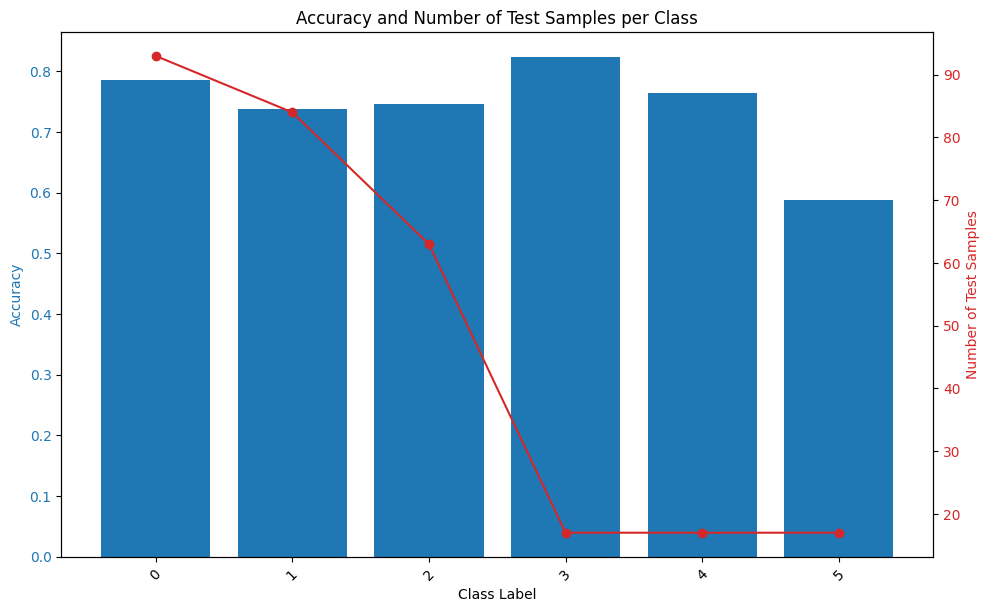

In [11]:
#plot evaluation
import matplotlib.pyplot as plt

def accuracy_per_class(predictions, true_vals):
    pred_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = true_vals.flatten()
    accuracy_dict = {}
    count_dict = {}
    for label in np.unique(labels_flat):
        y_preds = pred_flat[labels_flat == label]
        y_true = labels_flat[labels_flat == label]
        accuracy_dict[label] = np.sum(y_preds == y_true) / len(y_true)
        count_dict[label] = len(y_true)
    return accuracy_dict, count_dict

accuracy_dict, count_dict = accuracy_per_class(predictions, true_vals)

print(accuracy_dict, count_dict )

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot accuracy
color = 'tab:blue'
ax1.set_xlabel('Class Label')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(accuracy_dict.keys(), accuracy_dict.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Show class labels instead of class indices
ax1.set_xticks(list(accuracy_dict.keys()))
ax1.set_xticklabels(list(accuracy_dict.keys()), rotation=45)

# Plot number of samples
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Test Samples', color=color)
ax2.plot(count_dict.keys(), count_dict.values(), color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Accuracy and Number of Test Samples per Class')
plt.show()


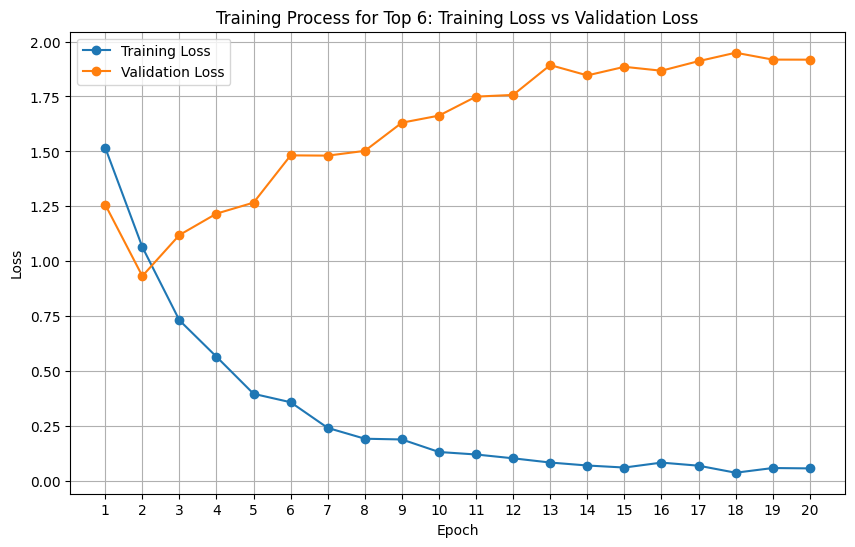

In [13]:
import matplotlib.pyplot as plt

# Training process data
epochs = list(range(1, 21))
training_loss = [
    1.5169395286193008, 1.0651671712853246, 0.7317207703987757, 0.5659425836536534, 0.39732526457721296,
    0.35895635862074654, 0.2422305387084747, 0.1930208744095555, 0.18964698035778044, 0.13267094111834138,
    0.12130455824230875, 0.10390949362572491, 0.08470123118404507, 0.07120360153438396, 0.061938265343740764,
    0.08435819080745348, 0.07035841584029404, 0.03835723933578178, 0.05970283143142922, 0.058046577391802745
]
validation_loss = [
    1.2577813876001802, 0.932987610567106, 1.1198246288432243, 1.2170742127074772, 1.2671705273247948,
    1.48212594125254, 1.4809367226042836, 1.5025878102807264, 1.6307400212286691, 1.662934480618912,
    1.7493451142696383, 1.7571665612240768, 1.8928840579766038, 1.8458737492336483, 1.8849290895332784,
    1.8671614050453333, 1.910753901749658, 1.9490782537715658, 1.9177794504957753, 1.9175005235160265
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Process for Top 6: Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.xticks(epochs)
plt.show()


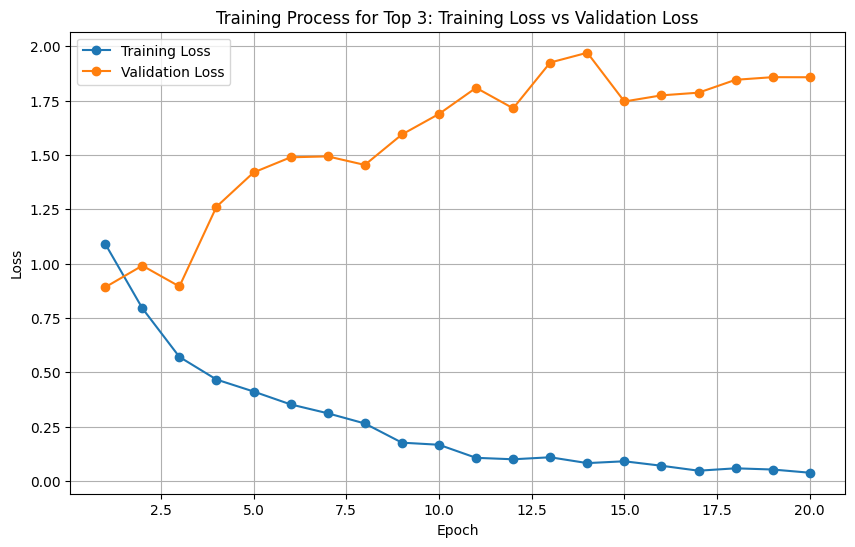

In [14]:
import matplotlib.pyplot as plt

# Training process data
epochs = list(range(1, 21))
training_loss = [
    1.0907365698367357, 0.7943849766937395, 0.5704602014273406, 0.4663612757702746, 0.41129675183910874,
    0.3519472770698485, 0.31114667393194395, 0.26419607239658943, 0.17593803875048858, 0.1662488707091446,
    0.10614659715502058, 0.09943508994844402, 0.1086651960307184, 0.0818482225059294, 0.0902011277942923,
    0.06967111376352478, 0.04686248739362782, 0.05788002544456201, 0.05228582202271355, 0.03757382329289006
]
validation_loss = [
    0.8912723700205485, 0.9905393429721395, 0.8947354583380123, 1.261674234631937, 1.4193431444912372,
    1.4891951781173702, 1.4933628013866838, 1.454079606102702, 1.5941054020882197, 1.688642717137312,
    1.8089524685271803, 1.7146185312172748, 1.9253071512824438, 1.970414726671758, 1.7459568461856785,
    1.7742023864579095, 1.786566859376641, 1.8458838209275805, 1.857896121127366, 1.8575567876042138
]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Process for Top 3: Training Loss vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


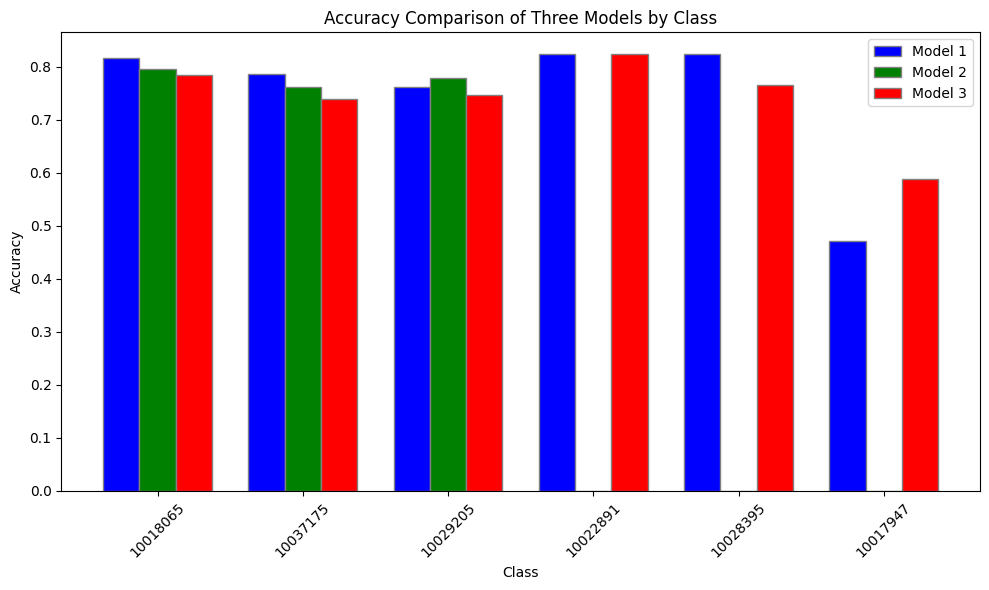

In [15]:
#comparing models
import matplotlib.pyplot as plt

# Data for three models
models = ['Model 1', 'Model 2', 'Model 3']
class_labels = ['10018065', '10037175', '10029205', '10022891', '10028395', '10017947']
accuracies_model_1 = [76/93, 66/84, 48/63, 14/17, 14/17, 8/17]
accuracies_model_2 = [74/93, 64/84, 49/63, 0, 0, 0]
accuracies_model_3 = [73/93, 62/84, 47/63, 14/17, 13/17, 10/17]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.25

# Set positions for each model
r1 = range(len(class_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]

# Plot bars for each model
ax.bar(r1, accuracies_model_1, color='b', width=bar_width, edgecolor='grey', label='Model 1')
ax.bar(r2, accuracies_model_2, color='g', width=bar_width, edgecolor='grey', label='Model 2')
ax.bar(r3, accuracies_model_3, color='r', width=bar_width, edgecolor='grey', label='Model 3')

# Add labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Three Models by Class')
ax.set_xticks([r + bar_width for r in range(len(class_labels))])
ax.set_xticklabels(class_labels)
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


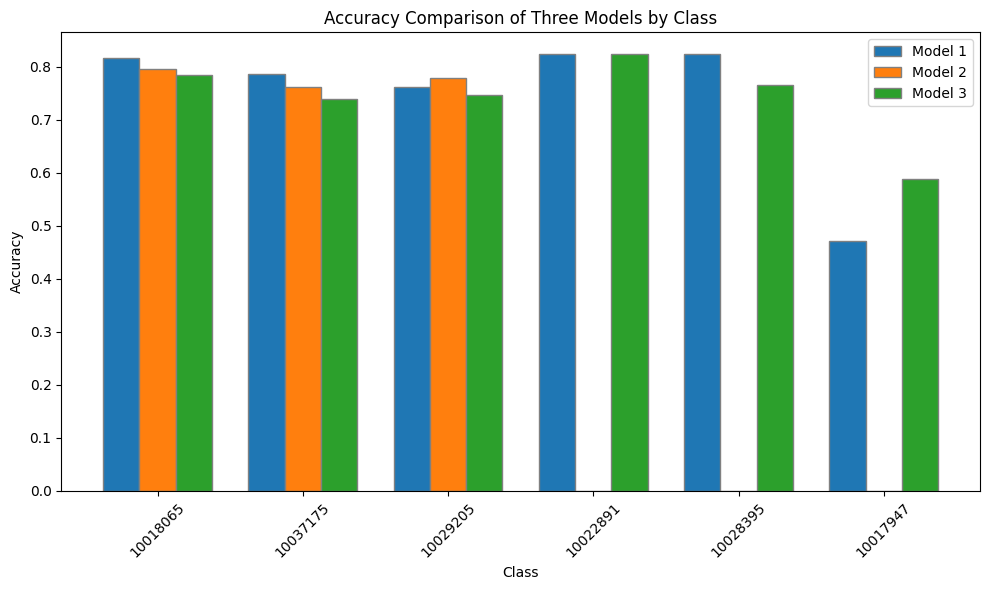

In [16]:
import matplotlib.pyplot as plt

# Data for three models
models = ['Model 1', 'Model 2', 'Model 3']
class_labels = ['10018065', '10037175', '10029205', '10022891', '10028395', '10017947']
accuracies_model_1 = [76/93, 66/84, 48/63, 14/17, 14/17, 8/17]
accuracies_model_2 = [74/93, 64/84, 49/63, 0, 0, 0]
accuracies_model_3 = [73/93, 62/84, 47/63, 14/17, 13/17, 10/17]

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Set bar width
bar_width = 0.25

# Set positions for each model
r1 = range(len(class_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width*2 for x in r1]

# Define colors for each model
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Plot bars for each model with custom colors
ax.bar(r1, accuracies_model_1, color=colors[0], width=bar_width, edgecolor='grey', label='Model 1')
ax.bar(r2, accuracies_model_2, color=colors[1], width=bar_width, edgecolor='grey', label='Model 2')
ax.bar(r3, accuracies_model_3, color=colors[2], width=bar_width, edgecolor='grey', label='Model 3')

# Add labels and title
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy Comparison of Three Models by Class')
ax.set_xticks([r + bar_width for r in range(len(class_labels))])
ax.set_xticklabels(class_labels)
ax.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
